In [46]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import time
import cv2
import io
import numpy as np

In [10]:
import sys
import os

# Add the directory containing the module to sys.path
module_path = os.path.abspath(os.path.join('../'))
sys.path.append(module_path)

import mytools
from mytools import *  

In [11]:
import os
from PIL import Image

# Path to the folder containing images
training_images_folder = 'dataset/training_data/images'

# List all files in the image folder
training_files = [f for f in os.listdir(training_images_folder) if f.endswith(('png', 'jpg', 'jpeg'))]


training_images = {}
# Loop through and open images
for training_file in training_files:
    image_path = os.path.join(training_images_folder, training_file)
    img = Image.open(image_path)
    
    training_images[training_file] = img
    
    


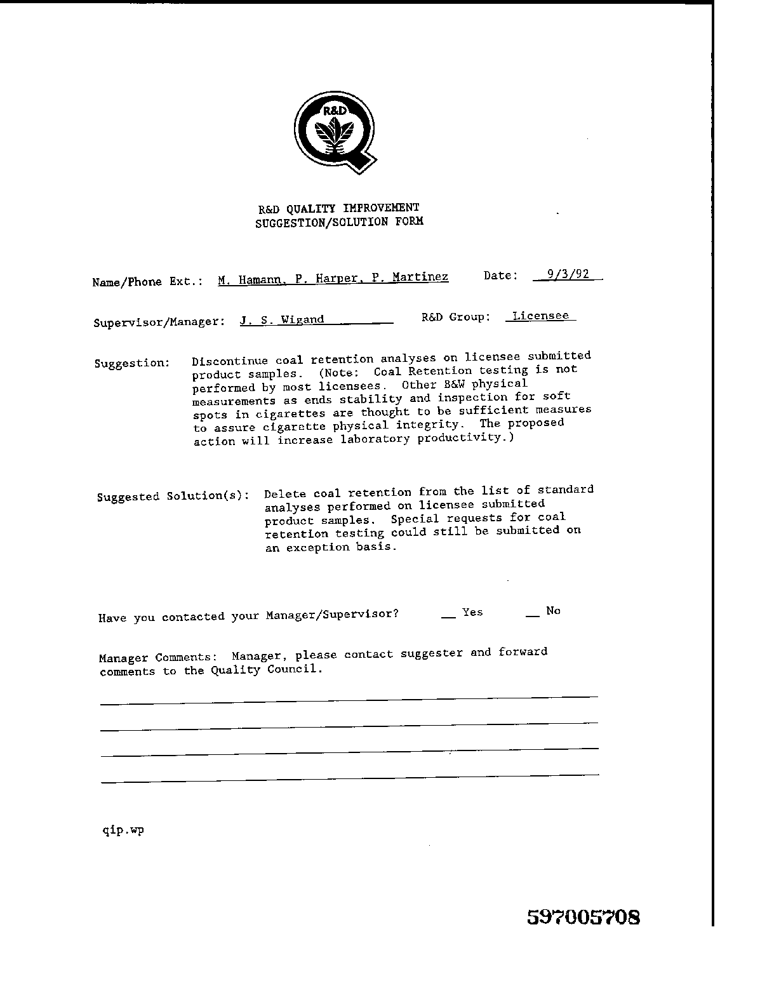

In [12]:
training_images_names = list(training_images.keys())
training_images[training_images_names[0]]

In [13]:
import os
from PIL import Image

# Path to the folder containing images
testing_images_folder = 'dataset/testing_data/images'

# List all files in the image folder
testing_files = [f for f in os.listdir(testing_images_folder) if f.endswith(('png', 'jpg', 'jpeg'))]

testing_images = {}
# Loop through and open images
for testing_file in testing_files:
    image_path = os.path.join(testing_images_folder, testing_file)
    img = Image.open(image_path)
    
    testing_images[testing_file] = img
    
testing_images_names = list(testing_images.keys())


In [60]:
def parse_result(result):
    final = {
        "text_lines": [],
    }
    
    if result.status == OperationStatusCodes.succeeded:
        read_results = result.analyze_result.read_results  # Contains all pages' OCR results
        for page in read_results:
            for line in page.lines:
                handwriting = 0
                if line.appearance.style.name=='handwriting': 
                    handwriting = 1
                    
                line_box = line.bounding_box
                line_box = quad_to_rect(line_box)
                
                final["text_lines"].append({
                    "line_text": line.text,
                    "line_bbox": line_box,
                    'handwriting': handwriting,
                    'words':[]
                })
        
                # Loop through each word in the line
                for word in line.words:                    
                    # Drawing word bounding boxes on the image
                    bbox = word.bounding_box
                    bbox = quad_to_rect(bbox)
                    final["text_lines"][-1]['words'].append({
                        'text':word.text,
                        'bbox':bbox
                    })
                       
    return final

In [132]:

def run_ocr_on_images(images_dict, langs =  ["en"]):
    images = list(images_dict.values())
    names = list(images_dict.keys())
    key = os.getenv('computer_vision_key')
    endpoint = os.getenv('computer_vision_endpoint')
    computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(key))

    global training_images_ocr 
    for i, image in enumerate(images[148:]):
        i = i + 148
        print('processing image', i , names[i])
        image = np.array(image)
        _, img_encoded = cv2.imencode('.jpg', image) 
        image_stream = io.BytesIO(img_encoded.tobytes())
        
        try:
            ocr_result = computervision_client.read_in_stream(image_stream, language="en", raw=True)
            operation_id = ocr_result.headers["Operation-Location"].split("/")[-1]
            # operation_id = 'cb446921-0df1-4c10-9268-77a8fd2d736b'
            while True:
                result = computervision_client.get_read_result(operation_id)
                if result.status not in [OperationStatusCodes.running, OperationStatusCodes.not_started]:
                    time.sleep(1)
                    break
                else: print('operation running')
                time.sleep(1)
            
            prediction = parse_result(result)
            
            training_images_ocr[names[i]] = prediction
            
        except Exception as e:
            print('Exception in ocr', e)
            return training_images_ocr
        
    return training_images_ocr

In [133]:
list(training_images.keys())[148]

'93455715.png'

In [87]:
# first_row = dict([next(iter(training_images.items()))])
testing_images_ocr = run_ocr_on_images(testing_images)

processing image 0 82092117.png
operation running
processing image 1 82200067_0069.png
operation running
processing image 2 82250337_0338.png
operation running
processing image 3 82251504.png
operation running
processing image 4 82252956_2958.png
operation running
processing image 5 82253058_3059.png
operation running
processing image 6 82253245_3247.png
operation running
processing image 7 82253362_3364.png
operation running
processing image 8 82254765.png
operation running
processing image 9 82491256.png
processing image 10 82504862.png
operation running
processing image 11 82562350.png
operation running
processing image 12 82573104.png
operation running
processing image 13 82837252.png
operation running
processing image 14 83443897.png
operation running
processing image 15 83553333_3334.png
operation running
processing image 16 83573282.png
processing image 17 83594639.png
operation running
processing image 18 83624198.png
operation running
processing image 19 83635935.png
operation

In [134]:
training_images_ocr = run_ocr_on_images(training_images)

processing image 148 93455715.png
operation running


In [124]:
training_images_ocr['00040534.png']

{'text_lines': [{'line_text': 'ACUTE TOXICITY IN MICE',
   'line_bbox': [291.0, 58.0, 511.0, 78.0],
   'handwriting': 0,
   'words': [{'text': 'ACUTE', 'bbox': [293.0, 59.0, 349.0, 79.0]},
    {'text': 'TOXICITY', 'bbox': [355.0, 59.0, 434.0, 77.0]},
    {'text': 'IN', 'bbox': [439.0, 59.0, 457.0, 77.0]},
    {'text': 'MICE', 'bbox': [465.0, 59.0, 510.0, 78.0]}]},
  {'line_text': 'COMPOUND',
   'line_bbox': [83.0, 108.0, 135.0, 120.0],
   'handwriting': 0,
   'words': [{'text': 'COMPOUND', 'bbox': [84.0, 109.0, 131.0, 121.0]}]},
  {'line_text': '3-Hydroxy-3-methylbutanoic acid (Tur 13)',
   'line_bbox': [143.0, 98.0, 507.0, 118.0],
   'handwriting': 0,
   'words': [{'text': '3-Hydroxy-3-methylbutanoic',
     'bbox': [144.0, 100.0, 380.0, 118.0]},
    {'text': 'acid', 'bbox': [390.0, 99.0, 427.0, 116.0]},
    {'text': '(Tur', 'bbox': [438.0, 99.0, 472.0, 116.0]},
    {'text': '13)', 'bbox': [481.0, 99.0, 507.0, 116.0]}]},
  {'line_text': 'Lorillard - Organic Chemistry',
   'line_bbox': 

In [135]:
len(testing_images_ocr) , len(training_images_ocr)

(50, 149)

In [91]:
import os
import json

# Path to the folder where results will be stored
testing_data_folder = 'dataset/testing_data'
surya_results_folder = os.path.join(testing_data_folder, 'azure_results')

# Create the directory if it doesn't exist
if not os.path.exists(surya_results_folder):
    os.makedirs(surya_results_folder)


testing_data_folder = 'dataset/training_data'
surya_results_folder = os.path.join(testing_data_folder, 'azure_results')

# Create the directory if it doesn't exist
if not os.path.exists(surya_results_folder):
    os.makedirs(surya_results_folder)


In [92]:
c=0
for key , val in testing_images_ocr.items():
    file_path = os.path.join('dataset/testing_data/azure_results', key.split('.')[0]+'.json')

    data_dict = val
    # Write the dictionary to a JSON file
    with open(file_path, 'w') as json_file:
        json.dump(data_dict, json_file, indent=4)

    print(f'Data successfully written to {file_path}')
    c+=1
c

Data successfully written to dataset/testing_data/azure_results\82092117.json
Data successfully written to dataset/testing_data/azure_results\82200067_0069.json
Data successfully written to dataset/testing_data/azure_results\82250337_0338.json
Data successfully written to dataset/testing_data/azure_results\82251504.json
Data successfully written to dataset/testing_data/azure_results\82252956_2958.json
Data successfully written to dataset/testing_data/azure_results\82253058_3059.json
Data successfully written to dataset/testing_data/azure_results\82253245_3247.json
Data successfully written to dataset/testing_data/azure_results\82253362_3364.json
Data successfully written to dataset/testing_data/azure_results\82254765.json
Data successfully written to dataset/testing_data/azure_results\82491256.json
Data successfully written to dataset/testing_data/azure_results\82504862.json
Data successfully written to dataset/testing_data/azure_results\82562350.json
Data successfully written to datas

50

In [136]:
c=0
for key , val in training_images_ocr.items():
    file_path = os.path.join('dataset/training_data/azure_results', key.split('.')[0]+'.json')

    data_dict = val
    # Write the dictionary to a JSON file
    with open(file_path, 'w') as json_file:
        json.dump(data_dict, json_file, indent=4)

    print(f'Data successfully written to {file_path}')
    c+=1
c

Data successfully written to dataset/training_data/azure_results\0000971160.json
Data successfully written to dataset/training_data/azure_results\0000989556.json
Data successfully written to dataset/training_data/azure_results\0000990274.json
Data successfully written to dataset/training_data/azure_results\0000999294.json
Data successfully written to dataset/training_data/azure_results\0001118259.json
Data successfully written to dataset/training_data/azure_results\0001123541.json
Data successfully written to dataset/training_data/azure_results\0001129658.json
Data successfully written to dataset/training_data/azure_results\0001209043.json
Data successfully written to dataset/training_data/azure_results\0001239897.json
Data successfully written to dataset/training_data/azure_results\0001438955.json
Data successfully written to dataset/training_data/azure_results\0001456787.json
Data successfully written to dataset/training_data/azure_results\0001463282.json
Data successfully written to

149